# Linear Regression with TensorFlow

Linear regression using tensorflow.

In this notebook we demonstrate two ways of fitting linear regression model to the data. 

The first approach is closed form exact solution based on the Normal Equation. 
The second approach uses the Maximum Likelihood Estimation (MLE).


In [1]:
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import tensorflow as tf

from tensorflow.python.layers import core as core_layers

In [2]:
# utility function
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### We use artificial data for the following regression

$ y(x) = a + b_1 \cdot X_1 + b_2 \cdot X_2 + b_3 \cdot X_3 + \sigma \cdot \varepsilon $ 

where $ \varepsilon \sim N(0, 1) $ is a Gaussian noise, and $ \sigma $ is its volatility, 
with the following choice of parameters:

$ a = 1.0 $

$ b_1, b_2, b_3 = (0.5, 0.2, 0.1) $

$ \sigma = 0.1 $

$ X_1, X_2, X_3 $ will be uniformally distributed in $ [-1,1] $

## Generate data

In [3]:
n_points = 5000
n_features = 3

bias = np.ones(n_points).reshape((-1,1))
low = - np.ones((n_points,n_features),'float')
high = np.ones((n_points,n_features),'float')

# simulated features
X = np.random.uniform(low=low, high=high)

# simulated noise
noise = np.random.normal(size=(n_points, 1))

# outputs 
weights = np.array([1.0, 0.5, 0.2, .1])
noise_std = 0.1
Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

# split to the train and test set
train_test_split = 4  # 1/4 of the data is used for a test

n_test = int(n_points/train_test_split)
n_train = n_points - n_test


X_train = X[:n_train,:]
Y_train = Y[:n_train].reshape((-1,1))

X_test = X[n_train:,:]
Y_test = Y[n_train:].reshape((-1,1))

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((3750, 3), (3750, 1), (1250, 3), (1250, 1))

### Linear Regression with Numpy

In [5]:
# add the column of ones
X = np.hstack((np.ones(n_train).reshape((-1,1)),X_train))

theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y_train)

print(theta_numpy)

[[0.99976731]
 [0.49798502]
 [0.20590588]
 [0.10005634]]


### Linear Regression with Sklearn

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[0.99976731]
 [0.49798502]
 [0.20590588]
 [0.10005634]]


### Linear Regression with TensorFlow

In [7]:
# add the column of ones
X_np = np.hstack((np.ones(n_train).reshape((-1,1)),X_train))


X = tf.constant(X_np, dtype=tf.float32, name="X")
y = tf.constant(Y_train, dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [8]:
theta_value

array([[0.99976736],
       [0.4979849 ],
       [0.20590575],
       [0.10005631]], dtype=float32)

## A simple class for Linear Regression 

Implements the Normal Equation and MLE solutions

In [25]:
class Model:
    
    def __init__(self, n_features, learning_rate=0.05, L=0):
        
        # input placeholders
        self.X = tf.placeholder(tf.float32, [None, n_features], name="X") 
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Y")
    
        # regression parameters for the analytical solution using the Normal equation
        self.theta_in = tf.placeholder(tf.float32, [n_features+1,None])

        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        data_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        
        XT = tf.transpose(data_plus_bias)
        
        #############################################
        # The normal equation for Linear Regression
        
        self.theta = tf.matmul(tf.matmul(
            tf.matrix_inverse(tf.matmul(XT, data_plus_bias)), XT), self.Y)

        
        # mean square error in terms of theta = theta_in
        self.lr_mse = tf.reduce_mean(tf.square(
            tf.matmul(data_plus_bias, self.theta_in) - self.Y))
               
        
        #############################################
        # Estimate the model using the Maximum Likelihood Estimation (MLE)
        
        # regression parameters for the Maximum Likelihood method
        # Note that there are n_features+2 parameters, as one is added for the intercept, 
        # and another one for the std of noise  
        self.weights = tf.Variable(tf.random_normal([n_features+2, 1]))
        
        # prediction from the model
        self.output = tf.matmul(data_plus_bias, self.weights[:-1, :])

        gauss = tf.distributions.Normal(loc=0.0, scale=1.0)

        # Standard deviation of the Gaussian noise is modelled as a square of the 
        # last model weight
        sigma = 0.0001 + tf.square(self.weights[-1]) 
        
#         pi = tf.constant(m.pi)
    
        log_LL = tf.log(0.00001 + (1/sigma) * gauss.prob((self.Y - self.output) / sigma ))  
        self.loss = - tf.reduce_mean(log_LL)
        
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), 
                           -self.loss)
        
            
    def generate_data(n_points = 10000, 
                      n_features = 3,
                      weights = np.array([1.0, 0.5, 0.2, .1]),
                      noise_std = 0.1):
        
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise
        
#         print('Shapes in generate data: ', X.shape, weights.shape, noise.shape, Y.shape)    
            
        return (X, Y)
    
        
def main():
    
    n_points = 5000
    
    n_features = 3
    learning_rate = 0.05
    
    # n_features + 1 weights (one for a constant feature)
    weights = np.array([1.0, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Make data
    (X,Y) = Model.generate_data(n_points=n_points,
                                n_features=n_features,
                                weights=weights,
                               noise_std=noise_std)
    
    # split to the train and test set
    train_test_split = 4  # 1/4 of the data is used for a test
    
    n_test = int(n_points/4)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    # print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    # create an instance of the Linear Regression model class  
    model = Model(n_features=n_features, 
                 learning_rate=learning_rate)

    ###################
    history = []

    load_model_from_disk = False
    ###################

    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        if load_model_from_disk:
            try:
                saver.restore(sess, './111.ckpt')
                print ("model loaded")
            except:
                print ("model not loaded")

        # Normal equation for Linear Regression
        theta_value = sess.run(model.theta, feed_dict={
            model.X: X_train,
            model.Y: Y_train
            })
    
        lr_mse_train = sess.run(model.lr_mse, feed_dict={
            model.X: X_train,
            model.Y: Y_train,
            model.theta_in: theta_value
        })
    
        lr_mse_test = sess.run(model.lr_mse, feed_dict={
            model.X: X_test,
            model.Y: Y_test,
            model.theta_in: theta_value
        })
    
        print ("====== Linear Regression with the Normal Equation ======")
        print(theta_value)
        print ("Linear regression train error:", lr_mse_train)    
        print ("Linear regression test error:", lr_mse_test)
    
    
        losses = []
        # Now train the MLE parameters 
        for i in range(0, 50000):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                model.X: X_train,
                model.Y: Y_train
                })
            
            losses.append(loss)
            if len(losses) % 100 == 0:
                test_loss = sess.run(model.loss, feed_dict={
                    model.X: X_test,
                    model.Y: Y_test,
                })
                train_loss = sess.run(model.loss, feed_dict={
                    model.X: X_train,
                    model.Y: Y_train,
                })
                # print (np.mean(losses), train_loss, test_loss)
                history.append([np.mean(losses), train_loss, test_loss])
                losses = []
            
        save_path = saver.save(sess, './111.ckpt')
        print('Saved session to %s' % save_path)

        # make test_prediction
        Y_test_predicted = sess.run(model.output, feed_dict={
            model.X: X_test
            })
    
        # output std sigma is a square of the last weight
        std_model = weights[-1]**2 
        print ("====== Linear Regression with Maximum Likelihood Estimation ======")
        print ("Negative Log-Likelihood:", loss)
        print ("MLE fitted parameters:")
        print(weights[0:-1]) 
        print('Fitted std of noise: ',std_model)
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
        ax.scatter(X_test[:,1], X_test[:,2], Y_test_predicted, s=1, c="#FF0000")
        plt.show()
 
        sess.close()    
    
    plt.figure()
    history = np.array(history)
    a, = plt.plot(history[2:,0], c="#0000FF", label="training error")
    b, = plt.plot(history[2:,1], c="#000000", label="in sample error (no dropout)")
    c, = plt.plot(history[2:,2], c="#ff0000", label="out of sample error")
    plt.legend(handles=[a,b,c])
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.show()

====== Linear Regression with the Normal Equation ======
[[0.99974054]
 [0.49755028]
 [0.19666712]
 [0.09531162]]
Linear regression train error: 0.0100460285
Linear regression test error: 0.009374323
Saved session to ./111.ckpt
====== Linear Regression with Maximum Likelihood Estimation ======
Negative Log-Likelihood: 0.8813586
MLE fitted parameters:
[[0.99972206]
 [0.49756137]
 [0.19664834]
 [0.09533853]]
Fitted std of noise:  [0.10012847]


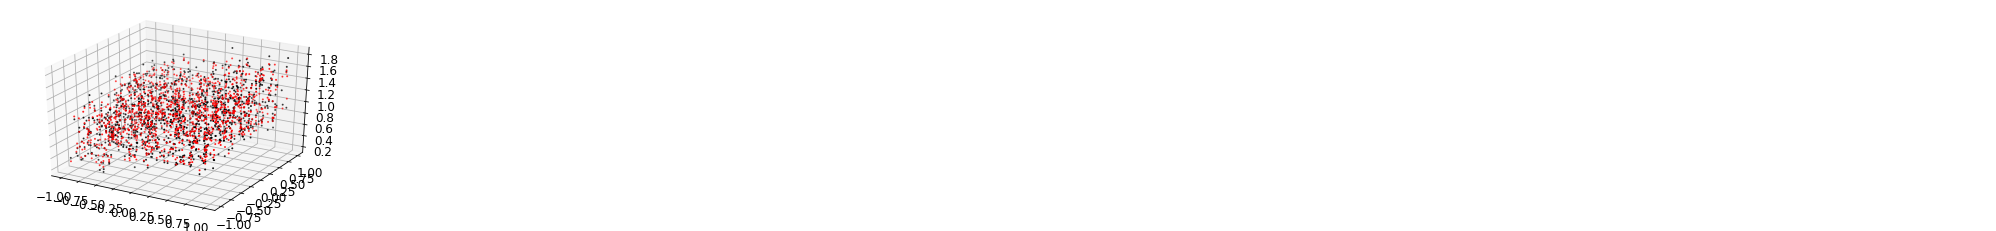

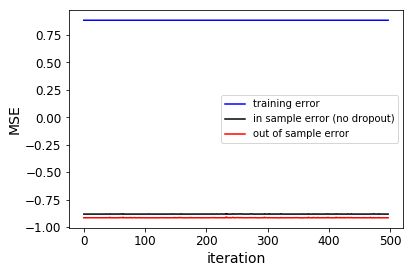

In [26]:
if __name__ == "__main__":
    main()

## A new class for Linear Regression with Stochastic Gradient Descent

In [11]:
class LR_Model_GD:
    def __init__(self, input_size=4, learning_rate=0.01):
        # input placeholders
        self.X = tf.placeholder(tf.float32, [None, input_size], name="X") # do not add the bias column !!
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Y")
        
        # Linear regression with the analytical formula
        data_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        XT = tf.transpose(data_plus_bias)
        self.theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, data_plus_bias)), XT), self.Y)
        
        # a placeholder for regression parameters 
        self.theta_in = tf.placeholder(tf.float32, [n_features+1,None])
   
        # Linear regression with Gradient Descent 
        self.layer = core_layers.Dense(1, dtype=tf.float32)
        self.layer.build([None, input_size])
        
        initial_weights = tf.random_uniform([input_size+1, 1], -1.0, 1.0, seed=42)
        self.weights_init = [
            self.layer.weights[0].assign(initial_weights[1:]),
            self.layer.weights[1].assign(initial_weights[1])
        ]
        
        PREDICTED_Y = self.layer(self.X )
        
        mse = tf.reduce_mean(tf.square(PREDICTED_Y - self.Y), name="mse")
        
        # mean square error in terms of theta = theta_in
        self.lr_mse = tf.reduce_mean(tf.square(
            tf.matmul(data_plus_bias, self.theta_in) - self.Y))
 
    
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        self.training_op = optimizer.minimize(mse)
        

In [12]:
batch_size = 20
n_epochs = 100

n_iterations = int((X_train.shape[0] / batch_size) * n_epochs)

#######################

reset_graph()

model = LR_Model_GD(input_size=n_features)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    theta_value = sess.run(model.theta, feed_dict={
        model.X: X_train,
        model.Y: Y_train
    })
    print ("====== Linear Regression with Normal Equation: ======")
    
    print(theta_value)
    
    lr_mse_insample = sess.run(model.lr_mse, feed_dict={
        model.X: X_train,
        model.Y: Y_train,
        model.theta_in: theta_value
    })
    print ("lr in-sample error:", lr_mse_insample)
        
    
    lr_mse = sess.run(model.lr_mse, feed_dict={
        model.X: X_test,
        model.Y: Y_test,
        model.theta_in: theta_value
    })
    print ("lr out-of-sample error:", lr_mse)

        
    # reset weights
    sess.run(model.weights_init)
    
    for i in range(0, n_iterations):
        batch_ids = np.random.randint(low=0, high=X_train.shape[0], size=batch_size).tolist()
        X_batch = X_train[batch_ids]
        Y_batch = Y.reshape([-1, 1])[batch_ids]
        sess.run(model.training_op, feed_dict={model.X: X_batch, model.Y: Y_batch})
    
    best_weights = sess.run(model.layer.weights)
    print ("====== Stochastic Gradient Fescent regression: ======")
    print (np.vstack([best_weights[1], best_weights[0]]))
    # .tolist()
    
    

====== Linear Regression with Normal Equation: ======
[[0.99976736]
 [0.4979849 ]
 [0.20590575]
 [0.10005631]]
lr in-sample error: 0.009970399
lr out-of-sample error: 0.010206205
====== Stochastic Gradient Fescent regression: ======
[[0.99799985]
 [0.49659255]
 [0.2024859 ]
 [0.09835599]]
